In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
sales.describe(percentiles=[0.03, 0.25, 0.5, 0.75, 0.97])

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
3%,0.000000e+00,4.000000e+00,1.307000e+03,7.900000e+01,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
97%,3.200000e+01,5.800000e+01,2.144000e+04,3.190000e+03,3.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


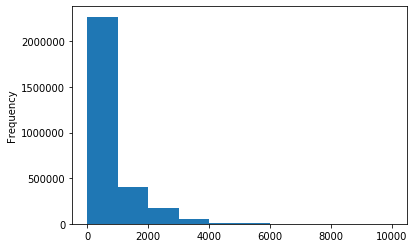

In [9]:
sales["item_price"].plot.hist(20, range=[0, 1e4])

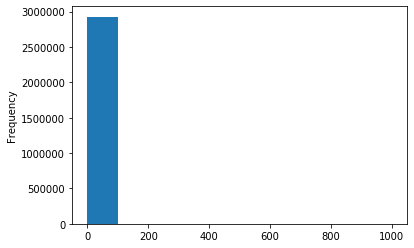

In [13]:
sales["item_cnt_day"].plot.hist(20, range=[0, 1e3])

# Aggregate data

In [16]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols).agg({'item_cnt_day': np.sum, 'item_price': np.mean}).reset_index()

#fix column names
gb.rename(index=str,columns={'item_cnt_day': 'item_cnt_month'},inplace=True)

#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [18]:
all_data.describe()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
count,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07
mean,3.118720e+01,1.130926e+04,1.497334e+01,3.342731e-01,1.166070e+02
std,1.734959e+01,6.209978e+03,9.495618e+00,3.417243e+00,6.584686e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,0.000000e+00
25%,1.600000e+01,5.976000e+03,7.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+01,1.139100e+04,1.400000e+01,0.000000e+00,0.000000e+00
75%,4.600000e+01,1.660500e+04,2.300000e+01,0.000000e+00,0.000000e+00
max,5.900000e+01,2.216900e+04,3.300000e+01,2.253000e+03,3.079800e+05


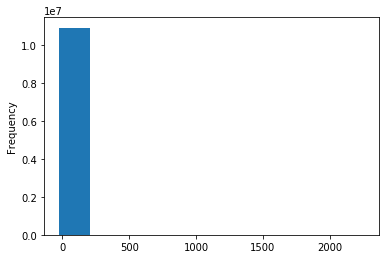

In [19]:
all_data.item_cnt_month.plot.hist(10)

In [20]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
139255,0,19,0,0.0,0.0
141495,0,27,0,0.0,0.0
144968,0,28,0,0.0,0.0
142661,0,29,0,0.0,0.0
138947,0,32,0,6.0,221.0


In [25]:
last_sales = all_data.groupby(["shop_id","item_id"])["item_cnt_month"].last().reset_index()
pred = pd.merge(test, last_sales, on=["shop_id", "item_id"], how="left")
pred.head()

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.0
1,1,5,5320,NaN
2,2,5,5233,1.0
3,3,5,5232,0.0
4,4,5,5268,NaN


In [26]:
pred["item_cnt_month"].fillna(0, inplace=True)
pred["item_cnt_month"] = pred["item_cnt_month"].map(lambda x: min(max(0, x), 20))

In [27]:
pred[["ID", "item_cnt_month"]].to_csv("submission_last_month.csv", index=False)